In [1]:
import os
import sys
os.environ["OMP_NUM_THREADS"] = "11"
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "11" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "11" # export NUMEXPR_NUM_THREADS=6
os.environ["NUMBA_CACHE_DIR"]='/tmp/numba_cache'
import numpy as np
import pandas as pd
import scipy as sp
import scipy.sparse
import h5py

import tensorflow as tf
import matplotlib.pyplot as plt
import scanpy as sc

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# Load data

In [2]:
with h5py.File('data/dogma_cite_asap.h5', 'r') as f:
    print(f.keys())
    peak_names = np.array(f['peak_names'], dtype='S32').astype(str)
    ADT_names = np.array(f['ADT_names'], dtype='S32').astype(str)
    gene_names = np.array(f['gene_names'], dtype='S32').astype(str)
    
    # Count matrices of three modalities: X for genes, Y for ADT, and Z for peaks.
    X = sp.sparse.csc_matrix(
        (np.array(f['RNA.data'], dtype=np.float32), 
         np.array(f['RNA.indices'], dtype=np.int32),
         np.array(f['RNA.indptr'], dtype=np.int32)
        ), 
        shape = np.array(f['RNA.shape'], dtype=np.int32)).tocsc().astype(np.float32)
    Y = np.array(f['ADT'], dtype=np.float32)
    Z = sp.sparse.csc_matrix(
        (np.array(f['peaks.data'], dtype=np.float32),
         np.array(f['peaks.indices'], dtype=np.int32),
         np.array(f['peaks.indptr'], dtype=np.int32)
        ), 
        shape = np.array(f['peaks.shape'], dtype=np.int32)).tocsc().astype(np.float32)
    cell_types = np.array(f['cell_types'], dtype='S32').astype(str)
    
    # The covariate matrix, the last column is the ids of datasets
    batches = np.array(f['batches'], dtype=np.float32)
    
    # The indices of features that are observed in each dataset.
    id_X_dogma = np.array(f['id_X_dogma'], dtype=np.int32)
    id_Y_dogma = np.array(f['id_Y_dogma'], dtype=np.int32)
    id_Z_dogma = np.array(f['id_Z_dogma'], dtype=np.int32)    
    id_X_cite = np.array(f['id_X_cite'], dtype=np.int32)
    id_Y_cite = np.array(f['id_Y_cite'], dtype=np.int32)
    id_Y_asap = np.array(f['id_Y_asap'], dtype=np.int32)
    id_Z_asap = np.array(f['id_Z_asap'], dtype=np.int32)
    
    # The sample size
    sample_sizes = np.array(f['sample_sizes'], dtype=np.int32)
    

# Count peaks in each chromosome (assuming they are ordered)
chunk_atac = np.array([
    np.sum(np.char.startswith(peak_names, 'chr%d-'%i)) for i in range(1,23)
    ], dtype=np.int32)
dim_input_arr = np.array([len(gene_names),len(ADT_names),len(peak_names)])
print(dim_input_arr)
    
# Preprocess the data
X = X.toarray()
X[batches[:,-1]!=2,:] = np.log(X[batches[:,-1]!=2,:]/np.sum(X[batches[:,-1]!=2,:], axis=1, keepdims=True)*1e4+1.)
Y = np.log(Y/np.sum(Y, axis=1, keepdims=True)*1e4+1.)
Z[Z>0.] = 1.
Z = Z.toarray()
data = np.c_[X, Y, Z]

# The masks indicate missing pattern for three datasets.
# -1 means missing and 0 means observed.
masks = - np.ones((3, np.sum(dim_input_arr)), dtype=np.float32)
masks[0,id_X_dogma] = 0.
masks[0,id_Y_dogma+dim_input_arr[0]] = 0.
masks[0,id_Z_dogma+np.sum(dim_input_arr[:2])] = 0.
masks[1,id_X_cite] = 0.
masks[1,id_Y_cite+dim_input_arr[0]] = 0.
masks[2,id_Y_asap+dim_input_arr[0]] = 0.
masks[2,id_Z_asap+np.sum(dim_input_arr[:2])] = 0.
masks = tf.convert_to_tensor(masks, dtype=tf.float32)

<KeysViewHDF5 ['ADT', 'ADT_names', 'RNA.data', 'RNA.indices', 'RNA.indptr', 'RNA.shape', 'batches', 'cell_ids', 'cell_types', 'gene_names', 'id_X_cite', 'id_X_dogma', 'id_Y_asap', 'id_Y_cite', 'id_Y_dogma', 'id_Z_asap', 'id_Z_dogma', 'peak_names', 'peaks.data', 'peaks.indices', 'peaks.indptr', 'peaks.shape', 'sample_sizes']>
[ 3660   227 38711]


2022-07-26 08:21:37.795853: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Set up config for model training

In [3]:
from scVAEIT.VAEIT import scVAEIT
path_root = 'result/ex3/full/'

config = {
    'dim_input_arr': dim_input_arr,
    'dimensions':[256], 
    'dim_latent':32,
    'dim_block': np.append([len(gene_names),len(ADT_names)], chunk_atac), 
    'dist_block':['NB','NB'] + ['Bernoulli' for _ in chunk_atac], 
    'dim_block_enc':np.array([256, 128] + [16 for _ in chunk_atac]),
    'dim_block_dec':np.array([256, 128] + [16 for _ in chunk_atac]),
    'block_names':np.array(['rna', 'adt'] + ['atac' for _ in range(len(chunk_atac))]),
    'uni_block_names':np.array(['rna','adt','atac']),
    'dim_block_embed':np.array([16, 8] + [1 for _ in range(len(chunk_atac))])*2,

    'beta_kl':1.,
    'beta_unobs':2./3.,
    'beta_modal':np.array([0.14,0.85,0.01]),
    'beta_reverse':0.,

    "p_feat" : 0.2,
    "p_modal" : np.ones(3)/3,
    
}

model = scVAEIT(config, data, masks, batches)

/raid6/Jinhong/anaconda3/envs/py/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


We skip the training process here and load the model checkpoint directly.

```
model.train(
        valid=False, num_epoch=500, batch_size=512, save_every_epoch=50,
        verbose=True, checkpoint_dir=path_root+'checkpoint/')
```        

In [4]:
# load the model and ensure it is loaded successfully
checkpoint = tf.train.Checkpoint(net=model.vae)
epoch = 10
status = checkpoint.restore(path_root+'checkpoint/ckpt-{}'.format(epoch))
model.vae(tf.zeros((1,np.sum(model.vae.config.dim_input_arr))),
          tf.zeros((1,np.sum(model.vae.config.dim_input_arr))),
          tf.zeros((1,np.sum(model.batches.shape[1]))), 
          pre_train=True, L=1, training=False)
print(status)

2022-07-26 08:21:44.347912: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-26 08:21:44.494786: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2800125000 Hz


# Obtain integrative latent representations

In [5]:
# only utilize proteins
masks_ADT = masks.numpy().copy()
masks_ADT[:model.vae.config.dim_input_arr[0]] = -1.
masks_ADT[:,-model.vae.config.dim_input_arr[2]:] = -1.
masks_ADT = tf.convert_to_tensor(masks_ADT, dtype=tf.float32)
model.update_z(masks_ADT)

In [6]:
# the latent variables are stored in model.adata
map_dict = {0:'Control',1:'Stimulation'}
condition = np.array([map_dict[i] for i in batches[:,0]])
map_dict = {0:'DOGMA-seq',1:'CITE-seq',2:'ASAP-seq'}
dataset = np.array([map_dict[i] for i in batches[:,-1]])

model.adata.obs['Condition'] = condition
model.adata.obs['Condition'] = model.adata.obs['Condition'].astype("category")
model.adata.obs['Dataset'] = dataset
model.adata.obs['Dataset'] = model.adata.obs['Dataset'].astype("category")
model.adata.obs['Cell Types'] = cell_types
model.adata

AnnData object with n_obs × n_vars = 30987 × 32
    obs: 'Condition', 'Dataset', 'Cell Types'
    uns: 'neighbors'
    obsp: 'distances', 'connectivities'

Calculate UMAP ...


/raid6/Jinhong/anaconda3/envs/py/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Cell Types' as categorical


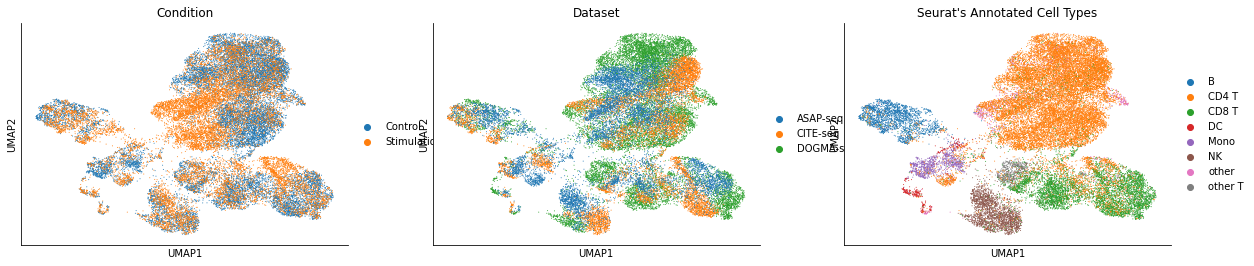

In [7]:
axes = model.visualize_latent(method = "UMAP", color = [
    'Condition','Dataset','Cell Types'], show=False)
axes[2].set_title("Seurat's Annotated Cell Types")


# Hide the right and top spines
axes[0].spines.right.set_visible(False)
axes[0].spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
axes[0].yaxis.set_ticks_position('left')
axes[0].xaxis.set_ticks_position('bottom')

axes[1].spines.right.set_visible(False)
axes[1].spines.top.set_visible(False)
axes[1].yaxis.set_ticks_position('left')
# axes[0].xaxis.set_ticks_position('bottom')

axes[2].spines.right.set_visible(False)
axes[2].spines.top.set_visible(False)
axes[2].yaxis.set_ticks_position('left')

# Visualize the denoised and imputed expressions

In [8]:
denoised_data = model.get_denoised_data(masks_ADT, zero_out=False)

adata = sc.AnnData(
    X=pd.DataFrame(data[:,:model.vae.config.dim_input_arr[0]], columns=gene_names))

adata.uns = model.adata.uns
adata.obsm = model.adata.obsm
adata.obs = model.adata.obs

adata_hat = sc.AnnData(
    X=pd.DataFrame(denoised_data[:,:model.vae.config.dim_input_arr[0]], columns=gene_names))

adata_hat.uns = model.adata.uns
adata_hat.obsm = model.adata.obsm
adata_hat.obs = model.adata.obs


/raid6/Jinhong/anaconda3/envs/py/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/raid6/Jinhong/anaconda3/envs/py/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


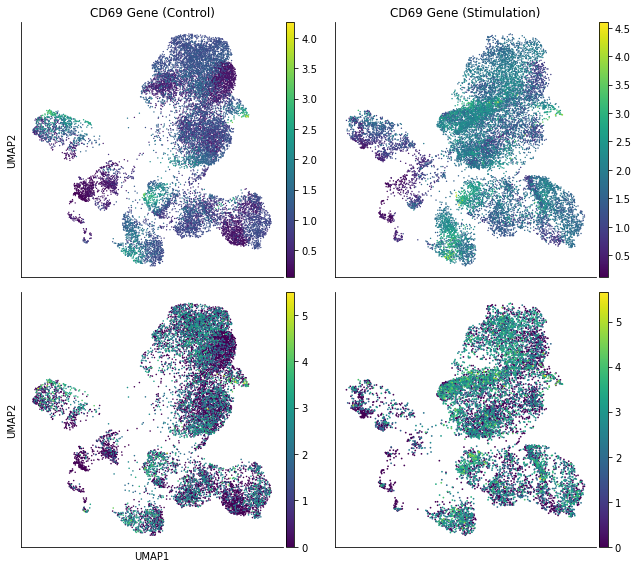

In [9]:
fig, axes = plt.subplots(2,2,figsize=(9,8))
sc.pl.umap(adata_hat[adata.obs['Condition']=='Control'], 
           color='CD69', ax=axes[0,0], show=False)
sc.pl.umap(adata_hat[adata.obs['Condition']!='Control'], 
           color='CD69', ax=axes[0,1], show=False)
sc.pl.umap(adata[(adata.obs['Dataset']!='ASAP-seq')&
    (adata.obs['Condition']=='Control')], 
           color='CD69', ax=axes[1,0], show=False)
sc.pl.umap(adata[(adata.obs['Dataset']!='ASAP-seq')&
    (adata.obs['Condition']!='Control')], 
           color='CD69', ax=axes[1,1], show=False)

for i in range(2):
    for j in range(2):
        
        # Hide the right and top spines
        axes[i,j].spines.right.set_visible(False)
        axes[i,j].spines.top.set_visible(False)

        # Only show ticks on the left and bottom spines
        axes[i,j].yaxis.set_ticks_position('left')
        axes[i,j].xaxis.set_ticks_position('bottom')
        
        axes[i,j].set_xlabel('')
        axes[i,j].set_ylabel('')
        axes[i,j].set_title('')
axes[1,0].set_xlabel('UMAP1')
axes[0,0].set_ylabel('UMAP2')
axes[1,0].set_ylabel('UMAP2')

axes[0,0].set_title('CD69 Gene (Control)')
axes[0,1].set_title('CD69 Gene (Stimulation)')

plt.tight_layout()

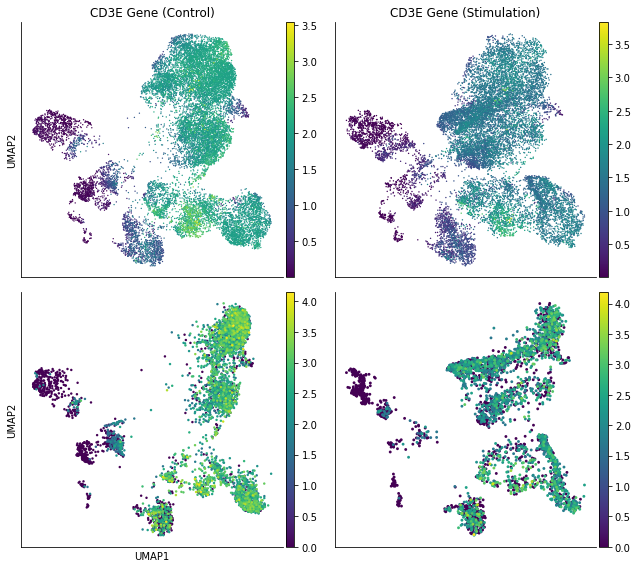

In [10]:
fig, axes = plt.subplots(2,2,figsize=(9,8))
sc.pl.umap(adata_hat[adata.obs['Condition']=='Control'], 
           color='CD3E', ax=axes[0,0], show=False)
sc.pl.umap(adata_hat[adata.obs['Condition']!='Control'], 
           color='CD3E', ax=axes[0,1], show=False)
sc.pl.umap(adata[(adata.obs['Dataset']=='CITE-seq')&
    (adata.obs['Condition']=='Control')], 
           color='CD3E', ax=axes[1,0], show=False)
sc.pl.umap(adata[(adata.obs['Dataset']=='CITE-seq')&
    (adata.obs['Condition']!='Control')], 
           color='CD3E', ax=axes[1,1], show=False)

for i in range(2):
    for j in range(2):
        
        # Hide the right and top spines
        axes[i,j].spines.right.set_visible(False)
        axes[i,j].spines.top.set_visible(False)

        # Only show ticks on the left and bottom spines
        axes[i,j].yaxis.set_ticks_position('left')
        axes[i,j].xaxis.set_ticks_position('bottom')
        
        axes[i,j].set_xlabel('')
        axes[i,j].set_ylabel('')
        axes[i,j].set_title('')
axes[1,0].set_xlabel('UMAP1')
axes[0,0].set_ylabel('UMAP2')
axes[1,0].set_ylabel('UMAP2')

axes[0,0].set_title('CD3E Gene (Control)')
axes[0,1].set_title('CD3E Gene (Stimulation)')


plt.tight_layout()